In [3]:
#import modules
import numpy as np
import os
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
import hdbscan
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sciAnalysis import *
from umap import umap_
import phate

/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


# Purpose:

I will use this notebook to test out an idea that Mike had regarding clustering my cells and estimating drive strength. He proposed that diving the cells into their proposed number of recombination breakpoints and then clustering within that class could allow me to get around issues with overclustering due to E0s. In order to test this I'll load in some HMM posterior data that I produced previously and import the viterbi decoding to detect the breakpoints. Then I will cluster by each class trying to use tSNE+DBSCAN or just DBSCAN. 

In [4]:
#init class
myAnalysis = analyzeSEQ()
myAnalysis.polarized_samples = myAnalysis.load_SNP_array('SPARSE_test_DATA_simV2.npy', '/home/iskander/Documents/Barbash_lab/mDrive/SIM_DATA', encoding='latin1')
HMM_posteriors = np.load('/home/iskander/Documents/Barbash_lab/mDrive/SIM_DATA/SPARSE_test_DATA_simV2_HMM_posteriors.npy')

SNP input loaded... 1165 cells read in...


Now that I have loaded data I will perform the viterbi ML decoding to determine the recombination breakpoints.

In [5]:
#instantiate dictionary to contain the indexes for each number of breakpoints 0-10
break_points = {}

for bp in range(11):
    break_points[bp] = []
    
#Iterate through individuals
cell_index = 0
for cell in myAnalysis.polarized_samples:
    
    filtered_cell, MO, MI = myAnalysis.filterNaN(cell)
    pointers = myAnalysis.hmmViterbi(snp_input=filtered_cell)
    ML_pred, ML_labels = myAnalysis.decode(pointers, filtered_cell)
    
    bp_num = 0
    for chrom in ML_pred:
        bp_num += len(chrom)
    break_points[bp_num].append(cell_index)
    cell_index += 1
    

Now I have used viterbi to detect the number of breakpoints in each cell lets try doing some clustering of them. For each of the clusterings I want to see how well it performs given the true labels and I suppose I should fully impute the dataset as well.

In [6]:
#Get true labels:
tsv_files = os.path.join('/home/iskander/Documents/Barbash_lab/mDrive/SIM_DATA/', 'test_DATA_simV2_crossovers.tsv')
CO_df = pd.read_csv(tsv_files, sep='\t', header=None)

In [7]:
true_labels = CO_df.values[:,0]

0.5452468099474806
0.6459289807537073


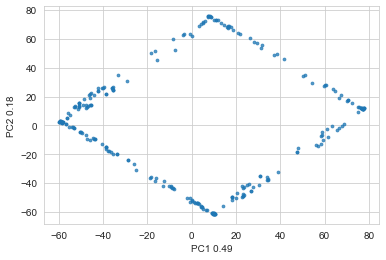

In [223]:
#### E1 #####
E1_data = HMM_posteriors[break_points[1]]
pca_fit = PCA(n_components=50).fit(E1_data.T)
pca_components = PCA(n_components=50).fit_transform(E1_data)

#tsne_embedding = TSNE(n_components=2, perplexity=5, early_exaggeration=len(pca_components)/3).fit_transform(pca_components)
true_labels_E1 = true_labels[break_points[1]]

#DBSCAN
db_labels_E1 = DBSCAN(eps=10, min_samples=1).fit(E1_data).labels_
ARI = metrics.adjusted_rand_score(true_labels_E1, db_labels_E1)
print(ARI)

#Hierachical
hier_labels_E1 = AgglomerativeClustering(n_clusters=None, distance_threshold=10, linkage='ward').fit(E1_data).labels_
ARI = metrics.adjusted_rand_score(true_labels_E1, hier_labels_E1)
print(ARI)


#plots
with sns.axes_style('whitegrid'):
    sns.scatterplot(pca_components[:,0], pca_components[:,1], edgecolor=None, alpha=.75, marker='.')
    plt.xlabel('PC1 {0:.2f}'.format(pca_fit.explained_variance_ratio_[0]))
    plt.ylabel('PC2 {0:.2f}'.format(pca_fit.explained_variance_ratio_[1]))
    plt.show()
    plt.close()

Short preliminary analysis on the E1s shows that clustering on the posterior probability or on principal components give similar results, but using the tSNE embedding gives very bad results. I am curious as to how well the clustering might perform on the actual sets of recombination breakpoints. For now I am going to wrap the above in a function so I can perform my clustering on all sets of individuals and see if there are any relationships between cluster calling quality and the 

In [8]:
def wrapClustering(E, pca=[]):
    posterior_data = HMM_posteriors[break_points[E]]
    true_E = true_labels[break_points[E]]
    
    
    if len(break_points[E]) > 1:
        #Hierachical
        if len(pca) != 0:
            pca_comp = pca[break_points[E]]
            
            #hier_labels = AgglomerativeClustering(n_clusters=None, distance_threshold=10, linkage='ward').fit(pca_comp).labels_
            hier_labels = DBSCAN(min_samples=1, eps=9).fit(pca_comp).labels_
            ARI = metrics.adjusted_rand_score(true_E, hier_labels)
            
            with sns.axes_style('whitegrid'):
                sns.scatterplot(pca_comp[:,0], pca_comp[:,1], edgecolor=None, alpha=.75, marker='.')
                plt.xlabel('PC1')
                plt.ylabel('PC2')
                plt.title(E)
                plt.show()
                plt.close()

            return ARI
        
        else:
            hier_labels = AgglomerativeClustering(n_clusters=None, distance_threshold=10, linkage='ward').fit(posterior_data).labels_
            ARI = metrics.adjusted_rand_score(true_E, hier_labels)
            return ARI

    else:
        return 0

As I cluster the various classes of cells I will try to cluster with and without PCA. For whatever reason my tSNE embeddings seem to be giving me all sorts of weird results.

In [9]:
ari_vector = np.zeros(shape=(2,11))
for i in range(11):
    ari_vector[0][i] = wrapClustering(E=i)

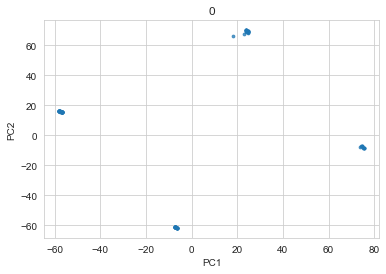

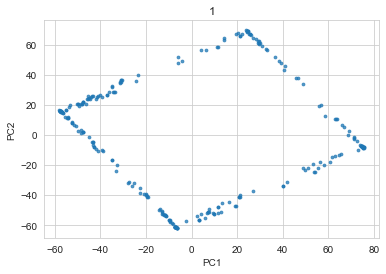

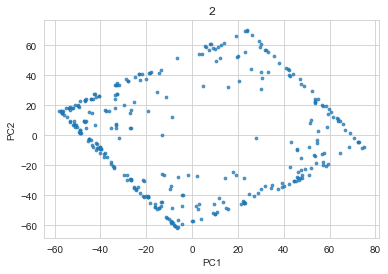

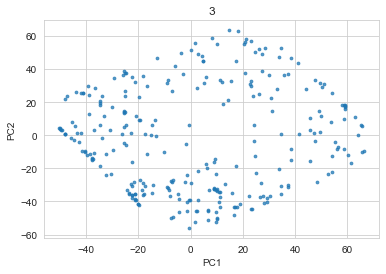

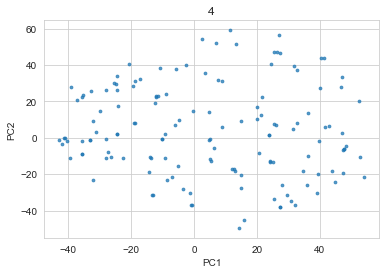

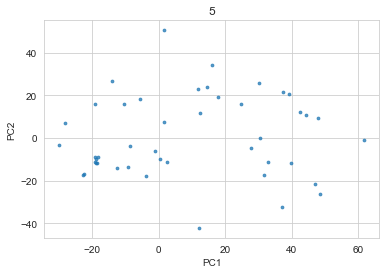

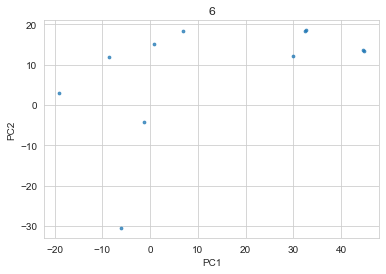

In [10]:
pca_fit = PCA(n_components=50).fit_transform(HMM_posteriors)
for i in range(11):
    ari_vector[1][i] = wrapClustering(E=i, pca=pca_fit)

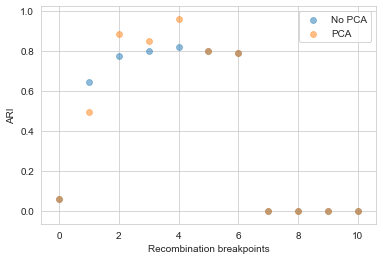

In [11]:
with sns.axes_style('whitegrid'):
    for i in range(2):
        sns.scatterplot([e for e in range(11)], ari_vector[i,:], edgecolor=None, alpha=.5, marker='o')
    plt.xlabel('Recombination breakpoints')
    plt.ylabel('ARI')
    plt.legend(['No PCA', 'PCA'])
    plt.show()
    plt.close()


The results of this analysis show marked improvement from the tSNE method as far as clustering is concerned. Predicatably, the E0 class clusters poorly for obvious reasons. The E1s do not cluster as well either, but still they are able to get around .6 ARI, which is not completely unreasonable. As we would expect, the quality  of our clustering increases as the number of breakpoints increases. I think I will try the same analysis, but use the recombination breakpoint predictions from the viterbi to cluster. In the case of E0s it would basically make them entire data set cluster as one blob that could be seperated based on P1 || P1/P2 states. However, for the others it might work better?

I want to try out PHATE maybe to see if it would work well. I have an idea for PHATE... Maybe this will work maybe not. Because the diffussion doesn't seem to work with small numbers of cells I can learn the manifold with all of my dataset and then cluster only individuals in their breakpoint classes. Unsure if this will improve results but let's try.

In [12]:
def wrapPHATE(E, embed):
    
    phate_embedding = embed[break_points[E]]
    true_E = true_labels[break_points[E]]
    
    
    if len(break_points[E]) > 1:
        #Hierachical
       
        #hier_labels = AgglomerativeClustering(n_clusters=None, distance_threshold=1, linkage='ward').fit(phate_embedding).labels_
        hier_labels = DBSCAN(min_samples=1, eps=1).fit(phate_embedding).labels_
        ARI = metrics.adjusted_rand_score(true_E, hier_labels)
            
        with sns.axes_style('whitegrid'):
            sns.scatterplot(phate_embedding[:,0], phate_embedding[:,1], edgecolor=None, alpha=.75, marker='.')
            plt.xlabel('PHATE1')
            plt.ylabel('PHATE2')
            plt.title('Recomb. breakpoints: '+str(E))
            plt.show()
            plt.close()

        return ARI
        

    else:
        return 0

Calculating PHATE...
  Running PHATE on 1165 cells and 21577 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 8.09 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.96 seconds.
    Calculating affinities...
    Calculated affinities in 0.11 seconds.
  Calculated graph and diffusion operator in 9.19 seconds.
  Calculating optimal t...
    Automatically selected t = 19
  Calculated optimal t in 1.84 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.89 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 8.24 seconds.
Calculated PHATE in 20.20 seconds.


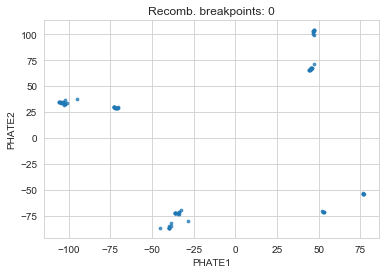

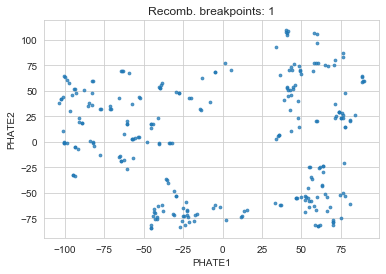

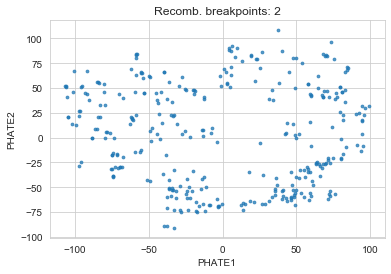

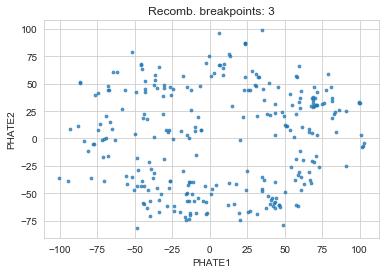

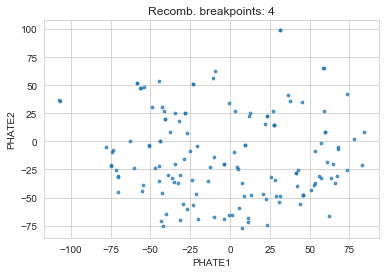

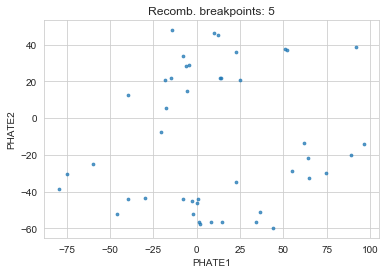

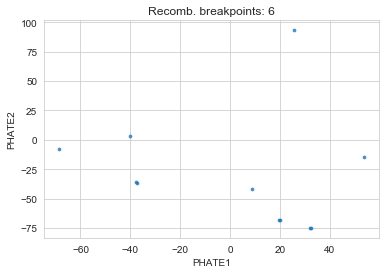

In [13]:
phate_scores = np.zeros(shape=(11))
embed = phate.PHATE().fit_transform(HMM_posteriors)
for e in range(11):
    phate_scores[e] = wrapPHATE(E=e, embed=embed)
    

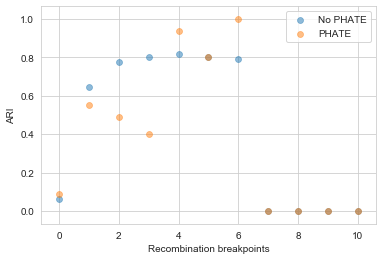

In [14]:
with sns.axes_style('whitegrid'):
    
    sns.scatterplot([e for e in range(11)], ari_vector[0,:], edgecolor=None, alpha=.5, marker='o')
    sns.scatterplot([e for e in range(11)], phate_scores, edgecolor=None, alpha=.5, marker='o')
    plt.xlabel('Recombination breakpoints')
    plt.ylabel('ARI')
    plt.legend(['No PHATE', 'PHATE'])
    plt.show()
    plt.close()

After a moderate amount of attempted parameter optimization for the clustering I've come to the conclusion that this performs generally worse than PCA. Although now I am curious if PCA+tSNE optimizations that I've been doing previously will work on this.

In [15]:
def wraptSNE(E,embed):
    
    if len(break_points[E]) > 1:
        tsne_embedding = embed[break_points[E]]
        #Hierachical
        true_E = true_labels[break_points[E]]
        #hier_labels = AgglomerativeClustering(n_clusters=None, distance_threshold=.1, linkage='ward').fit(tsne_embedding).labels_
        hier_labels = DBSCAN(eps=.15, min_samples=1).fit(tsne_embedding).labels_
        ARI = metrics.adjusted_rand_score(true_E, hier_labels)
            
        with sns.axes_style('whitegrid'):
            sns.scatterplot(tsne_embedding[:,0], tsne_embedding[:,1], edgecolor=None, alpha=.75, marker='.')
            plt.xlabel('tSNE1')
            plt.ylabel('tSNE2')
            plt.title('Recomb. breakpoints: '+str(E))
            plt.show()
            plt.close()

        return ARI
        

    else:
        return 0

In [27]:
#Initialize tSNE embedding
pca_comp = PCA(n_components=50).fit_transform(HMM_posteriors)    
tsne_embedding = TSNE(n_components=2, perplexity=50, early_exaggeration=len(HMM_posteriors)/3, init='pca').fit(pca_comp).embedding_

In [16]:
#Init tSNE embed with no PCA
tsne_embedding = TSNE(n_components=2, perplexity=50, early_exaggeration=len(HMM_posteriors)/3, init='pca').fit(HMM_posteriors).embedding_


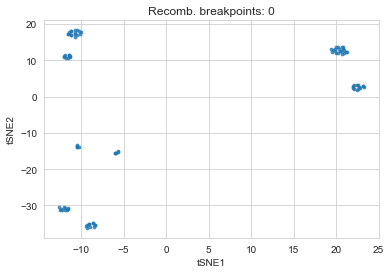

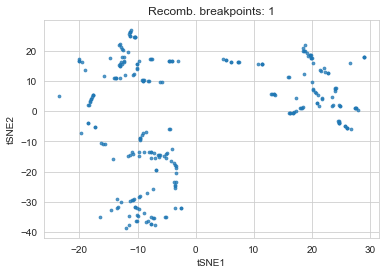

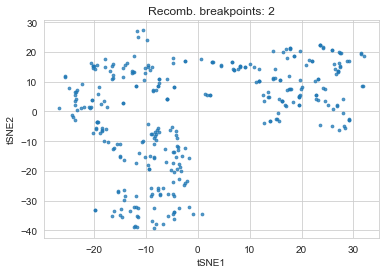

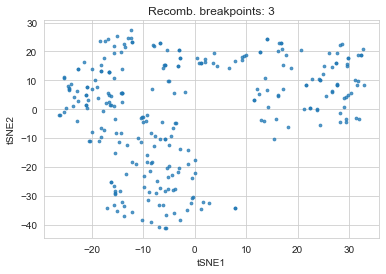

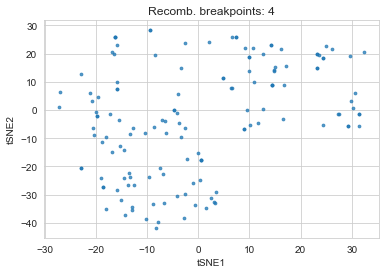

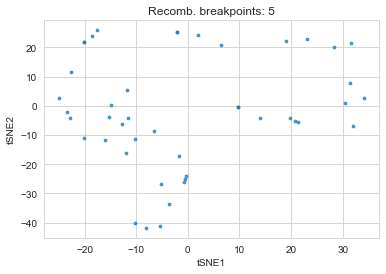

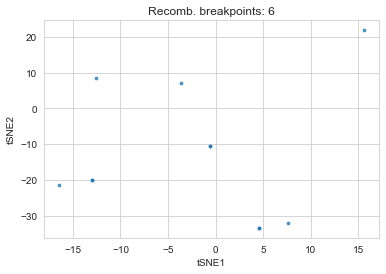

In [17]:
tsne_scores = np.zeros(shape=(11))
for e in range(11):
    tsne_scores[e] = wraptSNE(E=e, embed=tsne_embedding)

Next let's try UMAPs using the same trick of creating the embedding with the full data set and then clustering subsetting breakpoints

In [18]:
def wrapUMAP(E,embed):
    
    if len(break_points[E]) > 1:
        umap_embedding = embed[break_points[E]]
        #Hierachical
        true_E = true_labels[break_points[E]]
        #hier_labels = AgglomerativeClustering(n_clusters=None, distance_threshold=.1, linkage='ward').fit(umap_embedding).labels_
        hier_labels = DBSCAN(min_samples=1, eps=.1).fit(umap_embedding).labels_
        ARI = metrics.adjusted_rand_score(true_E, hier_labels)
            
        with sns.axes_style('whitegrid'):
            sns.scatterplot(umap_embedding[:,0], umap_embedding[:,1], edgecolor=None, alpha=.75, marker='.')
            plt.xlabel('UMAP1')
            plt.ylabel('UMAP2')
            plt.title('Recomb. breakpoints: '+str(E))
            plt.show()
            plt.close()

        return ARI
        

    else:
        return 0

In [19]:
UMAP = umap_.UMAP().fit_transform(HMM_posteriors)

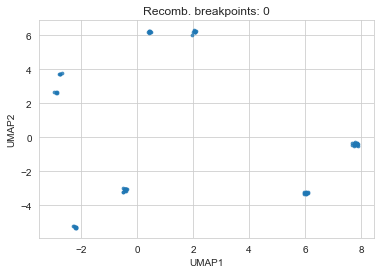

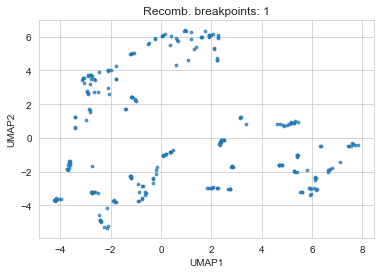

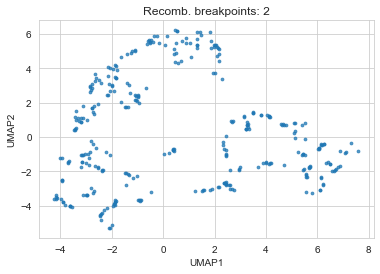

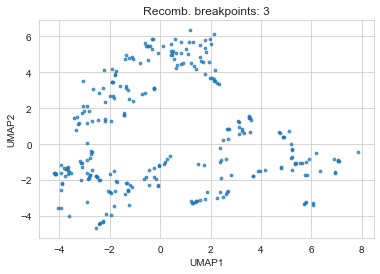

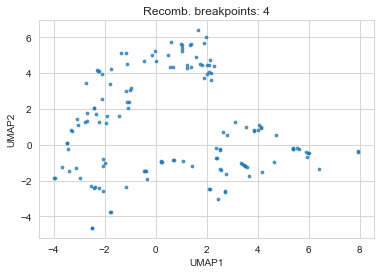

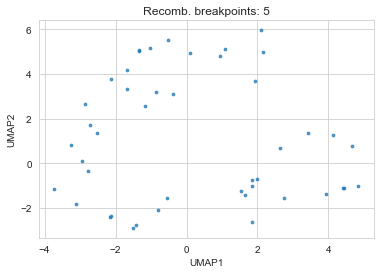

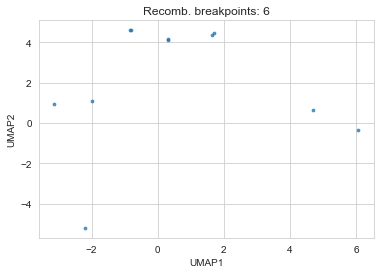

In [20]:
umap_scores = np.zeros(shape=(11))
for e in range(11):
    umap_scores[e] = wrapUMAP(E=e, embed=UMAP)

## Embedding benchmarks

As a further benchmarking of approaches I am going to compare the quality of scores for using various embeddings versus no embeddings in clustering.

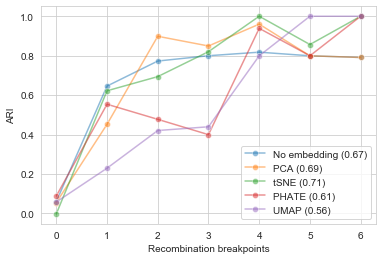

In [574]:
with sns.axes_style('whitegrid'): 
    sns.lineplot([e for e in range(7)], ari_vector[0,:7], alpha=.5, marker='o')
    sns.lineplot([e for e in range(7)], ari_vector[1,:7], alpha=.5, marker='o')
    sns.lineplot([e for e in range(7)], tsne_scores[0:7], alpha=.5, marker='o')
    sns.lineplot([e for e in range(7)], phate_scores[0:7], alpha=.5, marker='o')
    sns.lineplot([e for e in range(7)], umap_scores[0:7], alpha=.5, marker='o')
    plt.xlabel('Recombination breakpoints')
    plt.ylabel('ARI')
    plt.legend(['No embedding ({0:.2f})'.format(np.average(ari_vector[0,:][0:7])), 
                'PCA ({0:.2f})'.format(np.average(ari_vector[1,:][0:7])), 
                'tSNE ({0:.2f})'.format(np.average(tsne_scores[0:7])), 
                'PHATE ({0:.2f})'.format(np.average(phate_scores[0:7])),
                'UMAP ({0:.2f})'.format(np.average(umap_scores[0:7]))], loc='lower right')
    
    plt.show()
    plt.close()

Here we see tSNE is marginally better than the other approaches, but I wonder what the average ARI scores are when I exclude the E0s completely if this would be better than my previous approaches when my ARI was ~.7 w/ E0s.

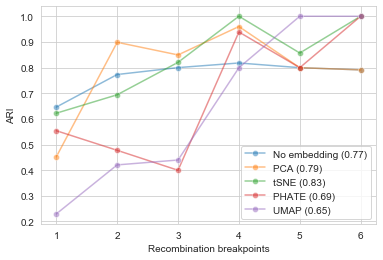

In [575]:
with sns.axes_style('whitegrid'): 
    sns.lineplot([e for e in range(1,7)], ari_vector[0,:][1:7], alpha=.5, marker='o')
    sns.lineplot([e for e in range(1,7)], ari_vector[1,:][1:7], alpha=.5, marker='o')
    sns.lineplot([e for e in range(1,7)], tsne_scores[1:7], alpha=.5, marker='o')
    sns.lineplot([e for e in range(1,7)], phate_scores[1:7], alpha=.5, marker='o')
    sns.lineplot([e for e in range(1,7)], umap_scores[1:7], alpha=.5, marker='o')
    plt.xlabel('Recombination breakpoints')
    plt.ylabel('ARI')
    plt.legend(['No embedding ({0:.2f})'.format(np.average(ari_vector[0,:][1:7])), 
                'PCA ({0:.2f})'.format(np.average(ari_vector[1,:][1:7])), 
                'tSNE ({0:.2f})'.format(np.average(tsne_scores[1:7])), 
                'PHATE ({0:.2f})'.format(np.average(phate_scores[1:7])),
                'UMAP ({0:.2f})'.format(np.average(umap_scores[1:7]))], loc='lower right')
    
    plt.show()
    plt.close()

A .83 average ARI with tSNE is not bad at all. That is a solid 10% better than my previous attempts.

## Conclusion:

The best approach in this case seems to be to use tSNE+PCA embedding on the posteriors and cluster on that underlying manifold seperately for each combination of breakpoints. Doing PCA is a close second however. I think either version of this approach would work fairly well.The biases that will arise is when initially breakpoints are not called. This will cause double counting of individuals. 

## Compute distribution of breakpoints:

So I can understand better how many breakpoints are present in the distribution of cells I want to get the underlying distribution. This way I can see how well my algorithm would work at predicting the number of breakpoints on the first pass. 

In [21]:
bp_calc = lambda x: len(x.split(',')) - 1
breakpoint_labels = CO_df.values[:,[3, 6, 9, 12, 15]]
BP_distr = np.sum(np.vectorize(bp_calc)(breakpoint_labels), axis=1)

true_dist = {}
for bp in range(11):
    true_dist[bp] = 0

for pos in BP_distr:
    true_dist[pos] += 1

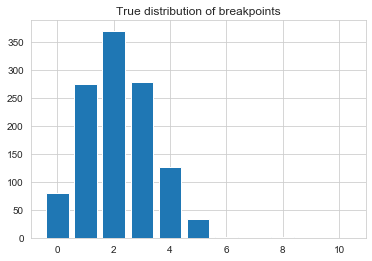

In [22]:
lab, total = zip(*sorted(true_dist.items(), key=operator.itemgetter(0)))

with sns.axes_style('whitegrid'):
    plt.bar(height=total, x=lab)
    plt.title('True distribution of breakpoints')
    plt.show()
    plt.close()

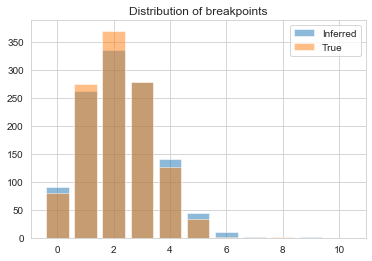

In [23]:
lab, total = zip(*sorted(break_points.items(), key=operator.itemgetter(0)))
tot_sum = []
for ele in total:
    tot_sum.append(len(ele))
    
lab, true_total = zip(*sorted(true_dist.items(), key=operator.itemgetter(0)))
with sns.axes_style('whitegrid'):
    plt.bar(height=tot_sum, x=lab, alpha=.5)
    plt.bar(height=true_total, x=lab, alpha=.5)
    plt.title('Distribution of breakpoints')
    plt.legend(['Inferred', 'True'])
    plt.show()
    plt.close()

In [24]:
print(list(true_total))#True distr
print(tot_sum)#Inferred distr

[80, 275, 370, 278, 127, 33, 1, 0, 1, 0, 0]
[90, 262, 335, 279, 141, 45, 11, 1, 0, 1, 0]


There is certainly some degree of error of over/under estimation of the number of breakpoints of my HMM, but I think over all it seems to classify segments pretty well. I think that breaking up my samples into the number of breakpoints could be a pretty good idea. 

Given that my distribution of breakpoints is uneven and that each dimension reduction / clustering algorithm works slightly differently at different breakpoints it may be a good idea to give different weights to each ARI value that is proportional to what that class makes up in the sample. For example 1 recombination breakpoint seems to make up roughly 1/5 of my sample so that ARI score should be weighted proportional to a fifth.


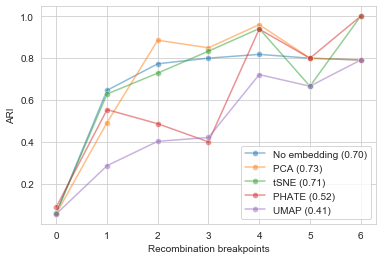

In [25]:
weight = tot_sum[0:7]
with sns.axes_style('whitegrid'): 
    sns.lineplot([e for e in range(7)], ari_vector[0,:7], alpha=.5, marker='o')
    sns.lineplot([e for e in range(7)], ari_vector[1,:7], alpha=.5, marker='o')
    sns.lineplot([e for e in range(7)], tsne_scores[0:7], alpha=.5, marker='o')
    sns.lineplot([e for e in range(7)], phate_scores[0:7], alpha=.5, marker='o')
    sns.lineplot([e for e in range(7)], umap_scores[0:7], alpha=.5, marker='o')
    plt.xlabel('Recombination breakpoints')
    plt.ylabel('ARI')
    plt.legend(['No embedding ({0:.2f})'.format(np.average(ari_vector[0,:][0:7], weights=weight)), 
                'PCA ({0:.2f})'.format(np.average(ari_vector[1,:][0:7],  weights=weight)), 
                'tSNE ({0:.2f})'.format(np.average(tsne_scores[0:7],  weights=weight)), 
                'PHATE ({0:.2f})'.format(np.average(phate_scores[0:7],  weights=weight)),
                'UMAP ({0:.2f})'.format(np.average(umap_scores[0:7],  weights=weight))], loc='lower right')
    
    plt.show()
    plt.close()

PCA and tSNE now have the same averages when weighted for sample size. I think this merits some further optimization.

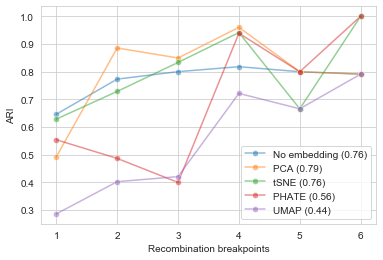

In [26]:
weight_2 = tot_sum[1:7]
with sns.axes_style('whitegrid'): 
    sns.lineplot([e for e in range(1,7)], ari_vector[0,:][1:7], alpha=.5, marker='o')
    sns.lineplot([e for e in range(1,7)], ari_vector[1,:][1:7], alpha=.5, marker='o')
    sns.lineplot([e for e in range(1,7)], tsne_scores[1:7], alpha=.5, marker='o')
    sns.lineplot([e for e in range(1,7)], phate_scores[1:7], alpha=.5, marker='o')
    sns.lineplot([e for e in range(1,7)], umap_scores[1:7], alpha=.5, marker='o')
    plt.xlabel('Recombination breakpoints')
    plt.ylabel('ARI')
    plt.legend(['No embedding ({0:.2f})'.format(np.average(ari_vector[0,:][1:7], weights = weight_2)), 
                'PCA ({0:.2f})'.format(np.average(ari_vector[1,:][1:7], weights = weight_2)), 
                'tSNE ({0:.2f})'.format(np.average(tsne_scores[1:7], weights = weight_2)), 
                'PHATE ({0:.2f})'.format(np.average(phate_scores[1:7], weights = weight_2)),
                'UMAP ({0:.2f})'.format(np.average(umap_scores[1:7], weights = weight_2))], loc='lower right')
    
    plt.show()
    plt.close()

Even without considering the E0s PCA and tSNE perform on average roughly the same across the breakpoint classes. I wonder if there are not some optimizations of PCA and tSNE that could be done here to tease out which strategy would work the best. 

## Optimization/Benchmark of PCA and tSNE methods:

In order to properly assay which method is best I need to optimize DBSCAN to each of the two methods. I'm choosing DBSCAN here rather than hierarchical clustering because of personal preference. Although hierarchical clustering is quite nice DBSCAN has given me marginally better results in the past. Ultimately I want to optimize the eps parameter as I'm fairly set in my ways on the tSNE parameters. I have played around enough with perplexity to know where the optimum lies. And actually come to think of it my eps parameter for tSNE DBSCAN has been thoroughly explored as well in previous docs so I can probably skip that as well...

In [587]:
def wrapPCA(E, eps, pca=[]):
    posterior_data = HMM_posteriors[break_points[E]]
    true_E = true_labels[break_points[E]]
    
    
    if len(break_points[E]) > 1:
        #Hierachical
        if len(pca) != 0:
            pca_comp = pca[break_points[E]]
            
            #hier_labels = AgglomerativeClustering(n_clusters=None, distance_threshold=10, linkage='ward').fit(pca_comp).labels_
            hier_labels = DBSCAN(min_samples=1, eps=eps).fit(pca_comp).labels_
            ARI = metrics.adjusted_rand_score(true_E, hier_labels)


            return ARI
        


    else:
        return 0

In [595]:
pca_comp = PCA(n_components=50).fit_transform(HMM_posteriors)    
weighted_avg_ARI = []
for epsilon in range(1, 26):
    
    ari_scores = []
    for E in range(1, 7):
        ARI = wrapPCA(E=E, eps= epsilon, pca=pca_comp)
        ari_scores.append(ARI)
    
    wARI = np.average(ari_scores, weights = weight_2)
    weighted_avg_ARI.append(wARI)


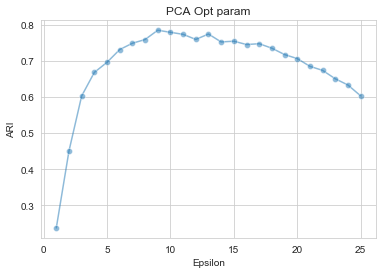

In [599]:
with sns.axes_style('whitegrid'):
    sns.lineplot([i for i in range(1,26)], weighted_avg_ARI, alpha=.5, marker='o')
    plt.xlabel('Epsilon')
    plt.ylabel('ARI')
    plt.title('PCA Opt param')
    plt.show()
    plt.close()

## Conclusion:

PCA and tSNE both work pretty well and under optimal parameter for this data set PCA really does seem to better in general. However, tSNE embeddings are stochastic and I can perform multiple iterations to find the best KL divergence. If we weight each E group by how much they contribute to the pool of cells then PCA seems to be better, wspecially at breakpoints = 2. I think that this is a good aspect however it does a not very good job at clustering under more breakpoints which is weird. Currently I'm going to implement the tSNE method because that's what I've been using in the past.